In [1]:
!pip install seaborn
!pip install ipywidgets
#!pip install hypnettorch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import scipy.stats
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=1)
torch.manual_seed(2)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)




# Define the target network
class TargetNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TargetNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, target_net, hyper_input_dim, hyper_hidden_dims):
        super(HyperNetwork, self).__init__()
        self.target_net = target_net
        layers = [] 
        if hyper_hidden_dims == []:
            layers.append(nn.Linear(hyper_input_dim, target_net.fc.weight.numel()))
        else:
            layers.append(nn.Linear(hyper_input_dim, hyper_hidden_dims[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hyper_hidden_dims)):
                layers.append(nn.Linear(hyper_hidden_dims[i-1],hyper_hidden_dims[i]))
            layers.append(nn.Linear(hyper_hidden_dims[-1], target_net.fc.weight.numel()))
        
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        params = self.model(alpha)
        params = params.view(self.target_net.fc.weight.size())
        self.target_net.fc.weight.data = params
        return self.target_net(x)

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def objective_h(self, risks, alpha_prime):
        def pdf_normal_distribution(x, alpha_prime):
            # Create a normal distribution centered at alpha' with std. 1 at alpha'
            likelihood = dist.normal.Normal(loc=alpha_prime, scale=0.1*alpha_prime+1e-10)
            # Calculate the probability density at the point x
            pdf = likelihood.log_prob(x).exp()
            return pdf
        alphas = dist.Uniform(0,1).sample((1000,1)).to(device)
        objective = 0
        weights = pdf_normal_distribution(alphas, alpha_prime)
        cvars = torch.stack([self.aggregator.aggregate(risks,alpha) for alpha in alphas])
        objective = (weights * cvars).mean()
        return objective
    
    def information_sharing(self, h, env_dict):
        learning_rate = 0.01
        num_epochs=100
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
        alpha_primes = torch.arange(0,1,0.05).to(self.device)
        for alpha_prime in alpha_primes:        
            print(f"alpha: {alpha_prime}")
            for epoch in range(num_epochs+1):
                risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device), h(env_dict[e]['x'].to(self.device), alpha_prime)) for e in env_dict.keys()])
                loss = self.objective_h(risks, alpha_prime)
                if epoch % 100 == 0:
                    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, param:{h.target_net.fc.weight.data.item()}")
                loss.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
        return
  
    def fit_h(self, h, env_dict):
        learning_rate = 0.01
        num_epochs=100
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
        alpha_primes = torch.arange(0,1,0.05).to(self.device)
        for alpha_prime in alpha_primes:        
            print(f"alpha: {alpha_prime}")
            for epoch in range(num_epochs+1):
                risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device), h(env_dict[e]['x'].to(self.device), alpha_prime)) for e in env_dict.keys()])
                loss = self.aggregator.aggregate(risks, alpha_prime)
                if epoch % 100 == 0:
                    print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, param:{h.target_net.fc.weight.data.item()}")
                loss.backward()
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
        return
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.01
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device),f(env_dict[e]['x'].to(self.device))) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 


**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

In [9]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 25
size_train, size_test = 100 , 100
theta_dist="beta" 
rho="cvar"
dim = 1
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
#fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

#ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
#ax.legend(loc='upper left')

alpha: 0.0
Epoch [0/100], Loss: 0.0, param:0.29569318890571594
Epoch [100/100], Loss: 0.0, param:0.29569318890571594
alpha: 0.05000000074505806
Epoch [0/100], Loss: 0.8808751106262207, param:0.30145958065986633
Epoch [100/100], Loss: 0.44753319025039673, param:0.30145958065986633
alpha: 0.10000000149011612
Epoch [0/100], Loss: 0.18796780705451965, param:0.307204008102417
Epoch [100/100], Loss: 0.4192618429660797, param:0.307204008102417
alpha: 0.15000000596046448
Epoch [0/100], Loss: 0.3010669946670532, param:0.32414260506629944
Epoch [100/100], Loss: 0.29239362478256226, param:0.32414260506629944
alpha: 0.20000000298023224
Epoch [0/100], Loss: 0.329755574464798, param:0.3417093753814697
Epoch [100/100], Loss: 0.38865432143211365, param:0.3417093753814697
alpha: 0.25
Epoch [0/100], Loss: 0.31715822219848633, param:0.35904061794281006
Epoch [100/100], Loss: 0.3263433873653412, param:0.35904061794281006
alpha: 0.30000001192092896
Epoch [0/100], Loss: 0.30683252215385437, param:0.37612769

  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.2304474264383316 param:  0.29569318890571594
alpha:  tensor(0.0500)  CVaR:  0.24198390543460846 param:  0.30145958065986633
alpha:  tensor(0.1000)  CVaR:  0.2529257833957672 param:  0.307204008102417
alpha:  tensor(0.1500)  CVaR:  0.2656102180480957 param:  0.32414260506629944
alpha:  tensor(0.2000)  CVaR:  0.2772907316684723 param:  0.3417093753814697
alpha:  tensor(0.2500)  CVaR:  0.2889215350151062 param:  0.35904061794281006
alpha:  tensor(0.3000)  CVaR:  0.30007538199424744 param:  0.376127690076828
alpha:  tensor(0.3500)  CVaR:  0.31228959560394287 param:  0.3929627239704132
alpha:  tensor(0.4000)  CVaR:  0.32584527134895325 param:  0.4090637266635895
alpha:  tensor(0.4500)  CVaR:  0.33808302879333496 param:  0.41909417510032654
alpha:  tensor(0.5000)  CVaR:  0.3523668646812439 param:  0.4290233254432678
alpha:  tensor(0.5500)  CVaR:  0.36893540620803833 param:  0.43884989619255066
alpha:  tensor(0.6000)  CVaR:  0.38677990436553955 param:  0.448572635

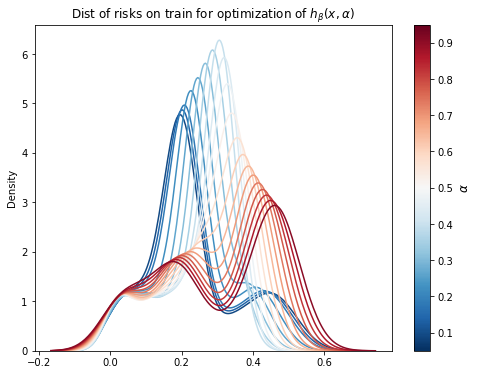

In [10]:
# Instantiate the target network and hypernetwork
target_net = TargetNetwork(input_dim=dim, output_dim=1)
h = HyperNetwork(target_net, hyper_input_dim=1, hyper_hidden_dims=[10]).cuda()
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).information_sharing(h, data_dict_train) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), h(data_dict_train[e]['x'].cuda(), alpha.cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on train for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

alpha: 0.0
Epoch [0/100], Loss: 0.8142938613891602, param:-0.16779421269893646
Epoch [100/100], Loss: 0.29916611313819885, param:-0.16779421269893646
alpha: 0.05000000074505806
Epoch [0/100], Loss: 0.312412828207016, param:-0.16979144513607025
Epoch [100/100], Loss: 0.3086317181587219, param:-0.16979144513607025
alpha: 0.10000000149011612
Epoch [0/100], Loss: 0.320101797580719, param:-0.1676008701324463
Epoch [100/100], Loss: 0.31994491815567017, param:-0.1676008701324463
alpha: 0.15000000596046448
Epoch [0/100], Loss: 0.3321402370929718, param:-0.1654086410999298
Epoch [100/100], Loss: 0.33191418647766113, param:-0.1654086410999298
alpha: 0.20000000298023224
Epoch [0/100], Loss: 0.3431433141231537, param:-0.1632147878408432
Epoch [100/100], Loss: 0.34291189908981323, param:-0.1632147878408432
alpha: 0.25
Epoch [0/100], Loss: 0.3557126224040985, param:-0.16101932525634766
Epoch [100/100], Loss: 0.3553163409233093, param:-0.16101932525634766
alpha: 0.30000001192092896
Epoch [0/100], Los

  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.29869699478149414 param:  -0.16779421269893646
alpha:  tensor(0.0500)  CVaR:  0.31038588285446167 param:  -0.16979144513607025
alpha:  tensor(0.1000)  CVaR:  0.32128211855888367 param:  -0.1676008701324463
alpha:  tensor(0.1500)  CVaR:  0.33254116773605347 param:  -0.1654086410999298
alpha:  tensor(0.2000)  CVaR:  0.3429650068283081 param:  -0.1632147878408432
alpha:  tensor(0.2500)  CVaR:  0.3547002077102661 param:  -0.16101932525634766
alpha:  tensor(0.3000)  CVaR:  0.36651280522346497 param:  -0.15882226824760437
alpha:  tensor(0.3500)  CVaR:  0.37792614102363586 param:  -0.15017445385456085
alpha:  tensor(0.4000)  CVaR:  0.3868251144886017 param:  -0.13707567751407623
alpha:  tensor(0.4500)  CVaR:  0.3973689079284668 param:  -0.1239287480711937
alpha:  tensor(0.5000)  CVaR:  0.40679290890693665 param:  -0.11073818802833557
alpha:  tensor(0.5500)  CVaR:  0.41630256175994873 param:  -0.09750846773386002
alpha:  tensor(0.6000)  CVaR:  0.4300835132598877 pa

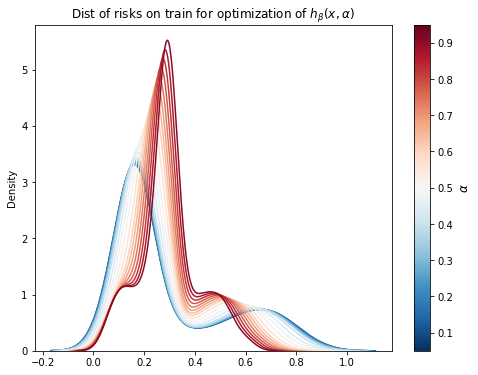

In [11]:
# Instantiate the target network and hypernetwork
target_net = TargetNetwork(input_dim=dim, output_dim=1)
h = HyperNetwork(target_net, hyper_input_dim=1, hyper_hidden_dims=[10]).cuda()
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).fit_h(h, data_dict_train) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), h(data_dict_train[e]['x'].cuda(), alpha.cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on train for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [100/100], Loss: 0.22552034258842468
alpha:  0.0 0.35787472128868103
 CVaR:  tensor(0.2255, device='cuda:0')
Epoch [100/100], Loss: 0.23629721999168396
alpha:  0.05 0.3609091341495514
 CVaR:  tensor(0.2363, device='cuda:0')
Epoch [100/100], Loss: 0.24681593477725983
alpha:  0.1 0.36276623606681824
 CVaR:  tensor(0.2468, device='cuda:0')
Epoch [100/100], Loss: 0.25691935420036316
alpha:  0.15 0.36850228905677795
 CVaR:  tensor(0.2569, device='cuda:0')
Epoch [100/100], Loss: 0.2653001844882965
alpha:  0.2 0.3698272705078125
 CVaR:  tensor(0.2653, device='cuda:0')
Epoch [100/100], Loss: 0.2735765278339386
alpha:  0.25 0.37952932715415955
 CVaR:  tensor(0.2736, device='cuda:0')
Epoch [100/100], Loss: 0.28091081976890564
alpha:  0.3 0.38852250576019287
 CVaR:  tensor(0.2809, device='cuda:0')
Epoch [100/100], Loss: 0.2886902689933777
alpha:  0.35 0.4017629325389862
 CVaR:  tensor(0.2887, device='cuda:0')
Epoch [100/100], Loss: 0.295583039522171
alpha:  0.4 0.4118959903717041
 CVaR:  te

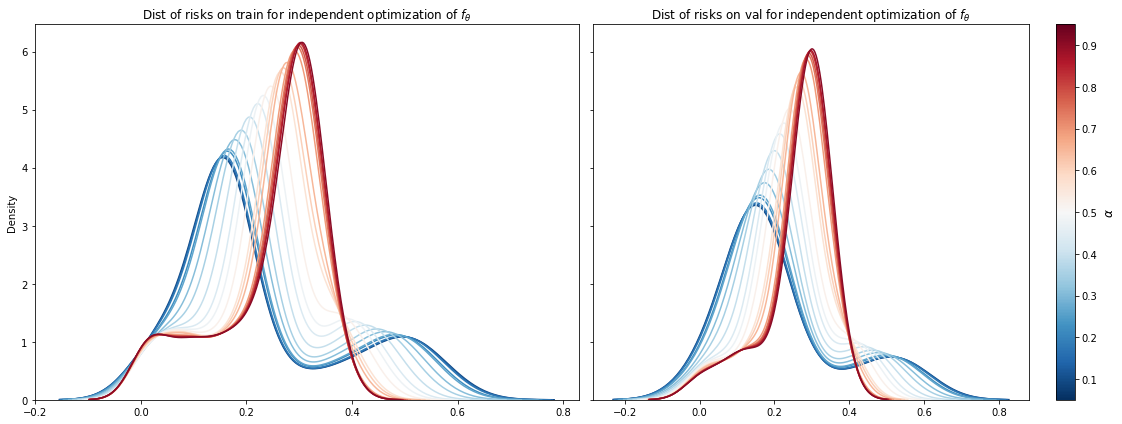

In [12]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
rg = range(0,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
f = FHatNetwork(dim,[],1).cuda()
for i in tqdm(rg):
    ARM_Regression(name=rho).fit_f(f, data_dict_train, i/100)  
    print("alpha: ", i/100, f.model.weight.data.item())
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), f(data_dict_train[e]['x'].cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.cpu().numpy(), ax=ax[0],color=diverging_colors[len(rg)-j], label=str(i/100))
        print(" CVaR: ",cvar_emp)
        #test 
        risks = torch.stack([loss_fn(data_dict_test[e]['y'].cuda(), f(data_dict_test[e]['x'].cuda())) for e in data_dict_test.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.cpu().numpy(), ax=ax[1],color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = f.state_dict()
    results.at[i, "cvar"] = cvar_emp
    j+=1

ax[0].legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax[1].legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')

ax[0].set_title(r"Dist of risks on train for independent optimization of $f_\theta$")
ax[1].set_title(r"Dist of risks on val for independent optimization of $f_\theta$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax[0].get_legend().remove()
ax[1].get_legend().remove()
# Add colorbar
ax[1].figure.colorbar(sm).set_label(label=r'$\alpha$', labelpad=5, size=12)
plt.tight_layout()
plt.show()